### Library Import

In [7]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import xgboost as xgb

# from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns


### Data Load

In [5]:
# drive.mount('/content/drive')

# 기본 경로 설정
base_path = "/data/ephemeral/home/JihoonRyu00/data/"

,target,hourly_market-data_open-interest_gate_io_btc_usd_open_interest,hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations,hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations_usd,hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations,hourly_market-data_liquidations_huobi_global_all_symbol_short_liquidations_usd,hourly_market-data_liquidations_huobi_global_all_symbol_short_liquidations,hourly_market-data_liquidations_huobi_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_huobi_global_all_symbol_long_liquidations,...,hourly_market-data_liquidations_htx_global_btc_usdt_long_liquidations_usd,hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations_usd,hourly_network-data_blockreward_blockreward_usd,hourly_network-data_addresses-count_addresses_count_active,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_addresses-count_addresses_count_sender,hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_usd,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations,ID
0,2.0,21461315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,1.248565e+06,67987,37752,37307,0.0,0.0,0.0,2023-01-01 00:00:00
1,1.0,21464662.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,4.176322e+05,30593,20534,12342,0.0,0.0,0.0,2023-01-01 01:00:00
2,1.0,21481446.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,8.321735e+05,33897,19369,17737,0.0,0.0,0.0,2023-01-01 02:00:00
3,1.0,21534989.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,5.199754e+05,32717,23799,11421,0.0,0.0,0.0,2023-01-01 03:00:00
4,2.0,21534219.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,7.286038e+05,45176,31712,17320,0.0,0.0,0.0,2023-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8852.6173,0.0,7.545328e+05,29250,13601,18154,0.0,0.0,0.0,2024-04-26 03:00:00
11548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88004.5038,0.0,1.466257e+06,56580,29096,31320,0.0,0.0,0.0,2024-04-26 04:00:00
11549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24154.4771,0.0,1.447081e+06,51858,22094,34083,0.0,0.0,0.0,2024-04-26 05:00:00
11550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17703.9134,0.0,9.307435e+05,36270,12668,26186,0.0,0.0,0.0,2024-04-26 06:00:00


In [ ]:
eda_diff_shifted_rolled=pd.read_csv(os.path.join(base_path, 'eda_diff_shifted_rolled_data.csv'))

In [4]:
# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = eda_diff_shifted_rolled["target"]
eda_diff_shifted_rolled = eda_diff_shifted_rolled.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train 분리
train_df = eda_diff_shifted_rolled.loc[eda_diff_shifted_rolled["_type"]=="train"].drop(columns=["_type"])
# test_df = eda_df_rolled_and_diff.loc[eda_diff_shifted_rolled["_type"]=="test"].drop(columns=["_type"])

train_df

,target,hourly_market-data_open-interest_gate_io_btc_usd_open_interest,hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations,hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations_usd,hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations,hourly_market-data_liquidations_huobi_global_all_symbol_short_liquidations_usd,hourly_market-data_liquidations_huobi_global_all_symbol_short_liquidations,hourly_market-data_liquidations_huobi_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_huobi_global_all_symbol_long_liquidations,...,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_sum_10h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_mean_12h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_std_12h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_sum_12h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_mean_24h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_std_24h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_sum_24h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_mean_168h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_std_168h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_sum_168h
0,2.0,21461315.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
1,1.0,21464662.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
2,1.0,21481446.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
3,1.0,21534989.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
4,2.0,21534219.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1.0,8229136.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.000000,...,0.280825,0.067836,0.167320,0.814035,0.581549,2.678321,13.957164,0.154823,1.090076,26.010258
8756,1.0,8218627.0,0.0,0.0,0.0,0.0,102175.4826,2.394,103766.3419,2.441000,...,0.280825,0.023402,0.081067,0.280825,0.581549,2.678321,13.957164,0.154823,1.090076,26.010258
8757,0.0,8213394.0,0.0,0.0,0.0,0.0,15757.4003,0.368,127.3455,0.003000,...,0.280825,0.023402,0.081067,0.280825,0.581549,2.678321,13.957164,0.154823,1.090076,26.010258
8758,2.0,8225802.0,0.0,0.0,0.0,0.0,7435.0124,0.175,264810.3290,6.266413,...,0.280825,0.023402,0.081067,0.280825,0.033918,0.120788,0.814035,0.154823,1.090076,26.010258


In [8]:
# 모델 훈련을 위한 X, y 분리 (target: 예측할 값)
X = train_df.drop(columns=['target', 'ID'])  # 타겟 변수 제외
y = train_df['target']  # 타겟 변수

# XGBoost 모델 생성 및 훈련
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # XGBoost 다중 클래스 분류
model.fit(X, y)

# 피처 중요도 추출
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})

In [9]:
# 중요도 순으로 정렬
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# 전체 피처에 대한 순위 추가
feature_importances_sorted['rank'] = np.arange(1, len(feature_importances_sorted) + 1)

# 상위 50개 중요도 피처
top_50_features = feature_importances_sorted.head(50)

# 중요도 상위 50개의 피처 이름 리스트
top_50_feature_names = top_50_features['feature'].tolist()

# eda_df_rolled_and_diff에서 상위 50개의 피처만 선택
top_50_data = eda_diff_shifted_rolled[top_50_feature_names + ['target', '_type', 'ID']]

# 상위 50개 피처를 포함한 데이터를 CSV로 저장
top_50_data.to_csv(os.path.join(base_path, 'top_50_important_features_data_XGB.csv'), index=False)


# 출력 너비 설정 (길게 출력되도록 설정)
pd.set_option('display.max_colwidth', None)

# 상위 50개 피처 출력
print("Top 50 Feature Importances with Ranking:")

top_50_features

Top 50 Feature Importances with Ranking:


,feature,importance,rank
8058,hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_rolling_std_6h,0.003657,1
6590,hourly_market-data_open-interest_bitfinex_btc_usdt_open_interest_rolling_mean_9h,0.002137,2
10106,hourly_market-data_taker-buy-sell-stats_all_exchange_taker_volume_diff_rolling_mean_5h,0.002010,3
52322,hourly_market-data_open-interest_huobi_global_all_symbol_open_interest_shift_24h_rolling_mean_168h,0.001925,4
144,hourly_market-data_taker-buy-sell-stats_binance_taker_buy_volume,0.001906,5
3842,hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume_rolling_mean_5h,0.001588,6
60,hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume,0.001343,7
8406,hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_rolling_std_2h,0.001231,8
3839,hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume_rolling_mean_4h,0.001080,9
2408,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume_rolling_mean_7h,0.000991,10


In [ ]:
df=pd.read_csv(os.path.join(base_path, 'top_50_important_features_data_XGB.csv'))

In [10]:
# df=top_50_data
# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
# _target = df["target"]

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

In [11]:
# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1),
    train_df["target"].astype(int),
    test_size=0.2,
    random_state=42,
)

# lgb dataset
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

# lgb params
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 1,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
)

# lgb predict
y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

/opt/conda/envs/bitcoin/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 50
[LightGBM] [Info] Start training from score -2.472992
[LightGBM] [Info] Start training from score -0.894135
[LightGBM] [Info] Start training from score -0.873416
[LightGBM] [Info] Start training from score -2.417056
acc: 0.4292237442922374, auroc: 0.6445744796941592


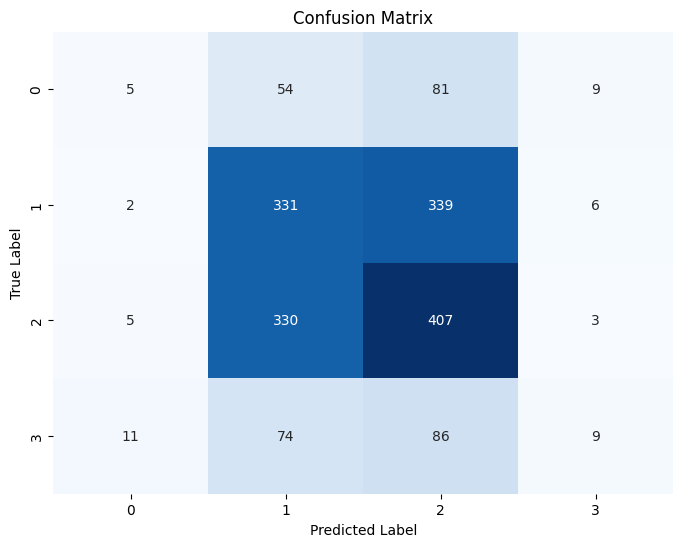

: 

In [12]:
from sklearn.metrics import confusion_matrix

# 혼동행렬 생성
conf_matrix = confusion_matrix(y_valid, y_valid_pred_class)

# 혼동행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()